# Table of Contents
* [1. Introduction](#1.-Introduction)
* [2. Difference in Wave Propagation](#2.-Difference-in-Wave-Propagation)
	* [2.1 O-mode in 1D Plasma](#2.1-O-mode-in-1D-Plasma)
		* [2.1.1 Dielectric element](#2.1.1-Dielectric-element)
		* [2.1.2 Phase Difference](#2.1.2-Phase-Difference)
		* [2.1.3 Wave Electric Field](#2.1.3-Wave-Electric-Field)
			* [2.1.3.1 Wave Amplitude](#2.1.3.1-Wave-Amplitude)
			* [2.1.3.2 Difference in E Field](#2.1.3.2-Difference-in-E-Field)
	* [2.2 X-mode in 1D plasma](#2.2-X-mode-in-1D-plasma)
		* [2.2.1 Dielectric element](#2.2.1-Dielectric-element)
		* [2.2.2 Phase Difference](#2.2.2-Phase-Difference)
		* [2.2.3 Wave Electric Field](#2.2.3-Wave-Electric-Field)
			* [2.2.3.1 Difference in E Field](#2.2.3.1-Difference-in-E-Field)
* [3. Phase difference as a function of temperature](#3.-Phase-difference-as-a-function-of-temperature)
	* [3.1 Phase Difference Curves](#3.1-Phase-Difference-Curves)
		* [3.1.1 O-mode](#3.1.1-O-mode)
		* [3.1.2 X-mode](#3.1.2-X-mode)
* [4. Conclusion](#4.-Conclusion)


# 1. Introduction

In this document, we will focus on perpendicularly incidental waves propagating in magnetized plasmas. In particular, we are interested in how cold electron model and weakly relativistic electron model differ in non-resonant regions. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pylab
%matplotlib inline

import FPSDP.Plasma.Analytical_Profiles.TestParameter as tp
import FPSDP.Maths.LightBeam as lb
import FPSDP.Models.Waves.Propagator as prop
import FPSDP.Plasma.DielectricTensor as dt
from FPSDP.GeneralSettings.UnitSystem import cgs

pylab.rcParams['figure.figsize'] = (10.0, 8.0)
pylab.rcParams['font.size'] = 20

# We use a extremely R_0 to simulate a uniform B field
R0 = 10000

tp.set_parameter1D(Te_0=15*cgs['keV'], Te_shape='uniform', ne_shape='uniform', R_0=R0, Xmin=R0-50, Xmax=R0+50)
p1d = tp.create_profile1D(False)

p1d.setup_interps()

c = cgs['c']
e = cgs['e']
m = cgs['m_e']
keV = cgs['keV']

B = p1d.get_B([R0])[0]
omega_c = e*B/(m*c)
omega = 2.2*omega_c

# 2. Difference in Wave Propagation

First, let's take a look at the result of wave propagation. This will give us an intuitive perspect of weakly relativistic effects.

In [2]:
y_min, y_max = -20, 20
z_min, z_max = -20, 20
ny = 64
nz = 64
start_plane = tp.Grid.Cartesian2D(DownLeft=(z_min,y_min), UpRight=(z_max,y_max), 
                                  NR=ny, NZ=nz)
x_start = R0+50
x_end = R0
nx = 250

Z2D,Y2D = start_plane.get_ndmesh()            
X2D = np.ones_like(Y2D)*x_start

wave_length = 2*np.pi*3e10/omega
gb = lb.GaussianBeam(wave_length, waist_x=x_start, waist_y=0, w_0y=3, tilt_h=0)

E_start = gb([Z2D, Y2D, X2D])

Z1D, Y1D = start_plane.get_mesh()

## 2.1 O-mode in 1D Plasma

In [3]:
propagator1d_cold = prop.ParaxialPerpendicularPropagator1D(plasma = p1d, 
                                                          dielectric_class = dt.ColdElectronColdIon, 
                                                          polarization = 'O', 
                                                          direction = -1)

propagator1d_rel = prop.ParaxialPerpendicularPropagator1D(plasma = p1d, 
                                                          dielectric_class = dt.RelElectronColdIon, 
                                                          polarization = 'O', 
                                                          direction = -1,
                                                          max_harmonic = 1,
                                                          max_power=1)

> In `propagate` method, we can set `debug_mode` to be `True`, so additional phase information will be retained after the calculation.

In [4]:
E1_cold = propagator1d_cold.propagate(omega, x_start, x_end, nx, E_start, Y1D, Z1D, debug_mode=True, 
                                      include_main_phase=True, mute=False)

Epsilon0 generated. Time used: 0.00107s
k0, ky, kz generated. Time used: 0.000804s
Delta_epsilon generated.Time used: 0.0564s
Polarization eigen-vector generated. Time used: 1.71e-06s
F function calculated. Time used: 0.0772s
Main phase generated. Time used: 0.0255
E field calculated. Time used: 0.083s
1D Propogation Finish! Check the returned E field. More infomation is available in Propagator object.
Total Time used: 0.22s



In [5]:
E1_rel = propagator1d_rel.propagate(omega, x_start, x_end, nx, E_start, Y1D, Z1D, debug_mode=True, 
                                    include_main_phase=True, mute=False)

Epsilon0 generated. Time used: 0.000332s
k0, ky, kz generated. Time used: 0.000462s
Delta_epsilon generated.Time used: 0.526s
Polarization eigen-vector generated. Time used: 1.42e-06s
F function calculated. Time used: 0.0748s
Main phase generated. Time used: 0.0254
E field calculated. Time used: 0.0832s
1D Propogation Finish! Check the returned E field. More infomation is available in Propagator object.
Total Time used: 0.686s



In [6]:
E1_diff = E1_rel - E1_cold

### 2.1.1 Dielectric element

In [7]:
P_cold = propagator1d_cold.eps0[2,2]

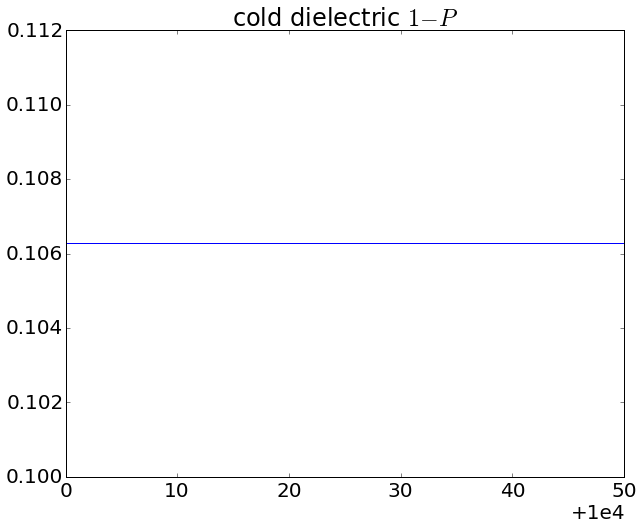

In [8]:
plt.plot(propagator1d_cold.x_coords, 1-np.real(P_cold))
plt.title('cold dielectric $1-P$')

In [9]:
dP_rel = propagator1d_rel.deps[2,2]

In [10]:
propagator1d_rel.central_kz

0

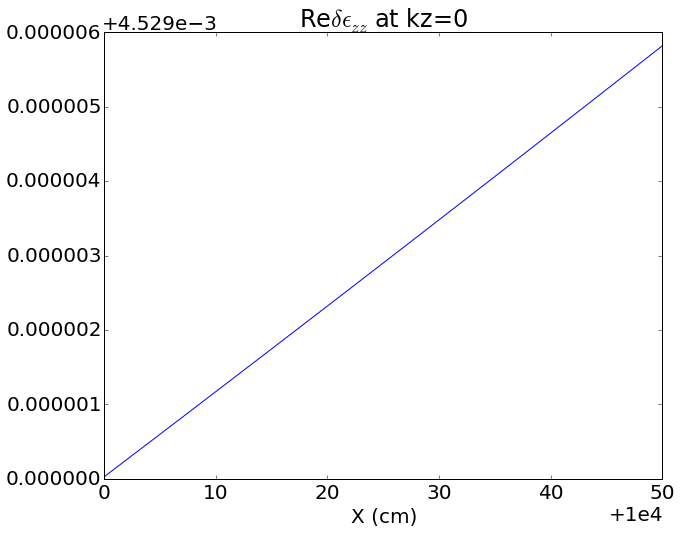

In [11]:
plt.plot(propagator1d_rel.x_coords, np.real(dP_rel[0,0]))
plt.title('Re$\delta \epsilon_{zz}$ at kz=0')
plt.xlabel('X (cm)')

> **The deviation is less than 5% for 15keV electrons. **

### 2.1.2 Phase Difference

> Detailed phase information is only available in `debug_mode`

In [12]:
phase_ky_cold = propagator1d_cold.dphi_ky
phase_kz_cold = propagator1d_cold.dphi_kz
phase_ky_rel = propagator1d_rel.dphi_ky 
phase_kz_rel = propagator1d_rel.dphi_kz 

In [13]:
np.max(np.abs(phase_ky_cold - phase_ky_rel))

0.0

In [14]:
np.max(np.abs(phase_kz_cold - phase_kz_rel))

0.0

> **From cold plasma to weakly relativistic plasma, the diffraction phase due to $k_y$ and $k_z$ doesn't change.**

In [15]:
phase_deps_cold = propagator1d_cold.dphi_eps
phase_deps_rel = propagator1d_rel.dphi_eps

In [16]:
np.max(np.abs(phase_deps_cold - phase_deps_rel))

3.0937127206687318

> **Phase due to dielectric tensor difference changes a little less than $\pi$**

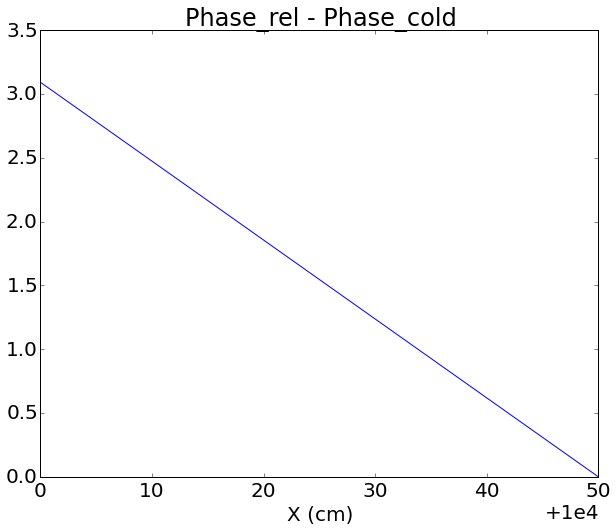

In [17]:
plt.plot(propagator1d_cold.x_coords, np.real(phase_deps_rel[0,0,:] - phase_deps_cold[0,0,:]))
plt.title('Phase_rel - Phase_cold')
plt.xlabel('X (cm)')

### 2.1.3 Wave Electric Field

#### 2.1.3.1 Wave Amplitude

C:\Users\lei\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


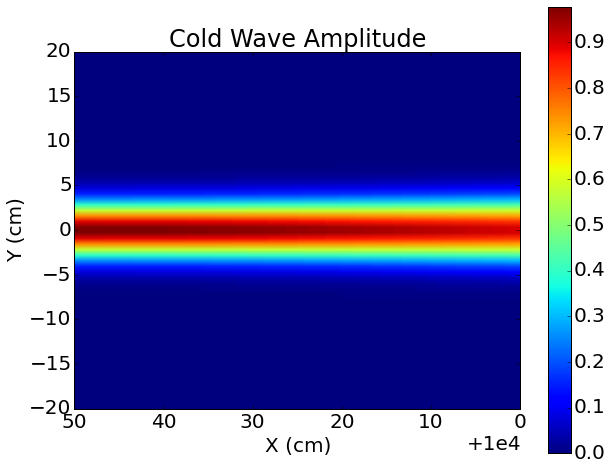

In [18]:
plt.imshow(np.abs(E1_cold[nz/2, :,:]), extent=[x_start, x_end, y_min, y_max], origin='lower')
plt.colorbar()
plt.title('Cold Wave Amplitude')
plt.xlabel('X (cm)')
plt.ylabel('Y (cm)')

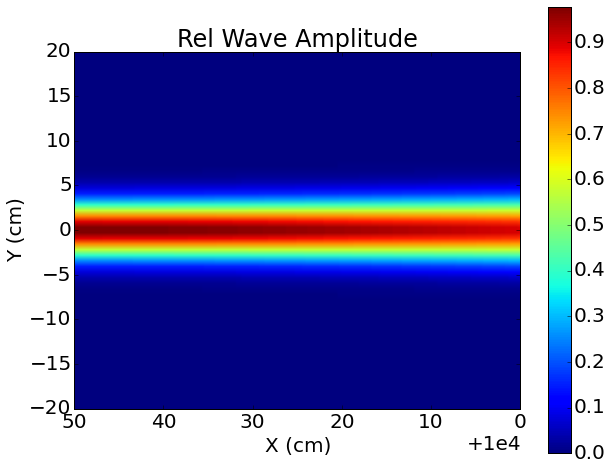

In [19]:
plt.imshow(np.abs(E1_rel[nz/2, :,:]), extent=[x_start, x_end, y_min, y_max], origin='lower')
plt.colorbar()
plt.title('Rel Wave Amplitude')
plt.xlabel('X (cm)')
plt.ylabel('Y (cm)')

#### 2.1.3.2 Difference in E Field

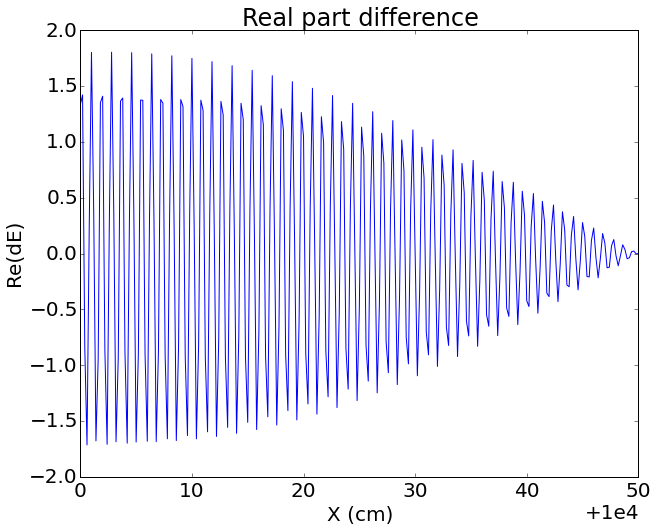

In [20]:
plt.plot(propagator1d_cold.x_coords, np.real(E1_diff[nz/2, ny/2, :]))
plt.title('Real part difference')
plt.xlabel('X (cm)')
plt.ylabel('Re(dE)')

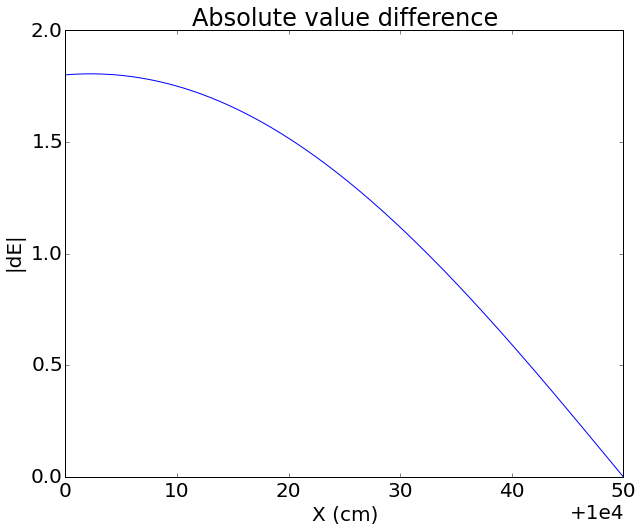

In [21]:
plt.plot(propagator1d_cold.x_coords, np.abs(E1_diff[nz/2, ny/2, :]))
plt.title('Absolute value difference')
plt.xlabel('X (cm)')
plt.ylabel('|dE|')

> **The difference in E field also shows the roughly $\pi$ phase shift over propagation.**

## 2.2 X-mode in 1D plasma

In [22]:
propagator1d_cold = prop.ParaxialPerpendicularPropagator1D(plasma = p1d, 
                                                          dielectric_class = dt.ColdElectronColdIon, 
                                                          polarization = 'X', 
                                                          direction = -1)

propagator1d_rel = prop.ParaxialPerpendicularPropagator1D(plasma = p1d, 
                                                      dielectric_class = dt.RelElectronColdIon, 
                                                      polarization = 'X', 
                                                      direction = -1,
                                                      max_harmonic = 3,
                                                      max_power = 3)

In [23]:
E1_cold = propagator1d_cold.propagate(omega, x_start, x_end, nx, E_start, Y1D, Z1D, debug_mode=True, 
                                      include_main_phase=True, mute=False)

Epsilon0 generated. Time used: 0.00104s
k0, ky, kz generated. Time used: 0.000758s
Delta_epsilon generated.Time used: 0.0564s
Polarization eigen-vector generated. Time used: 4.3e-05s
F function calculated. Time used: 0.133s
Main phase generated. Time used: 0.0375
E field calculated. Time used: 0.095s
1D Propogation Finish! Check the returned E field. More infomation is available in Propagator object.
Total Time used: 0.289s



In [24]:
E1_rel = propagator1d_rel.propagate(omega, x_start, x_end, nx, E_start, Y1D, Z1D, debug_mode=True, 
                                    include_main_phase=True, mute=False)

Epsilon0 generated. Time used: 0.000336s
k0, ky, kz generated. Time used: 0.000452s
Delta_epsilon generated.Time used: 1.77s
Polarization eigen-vector generated. Time used: 5.21e-05s
F function calculated. Time used: 0.139s
Main phase generated. Time used: 0.0375
E field calculated. Time used: 0.0943s
1D Propogation Finish! Check the returned E field. More infomation is available in Propagator object.
Total Time used: 2.01s



In [25]:
E1_diff = E1_rel - E1_cold

### 2.2.1 Dielectric element

In [26]:
S_cold = propagator1d_cold.eps0[0,0]

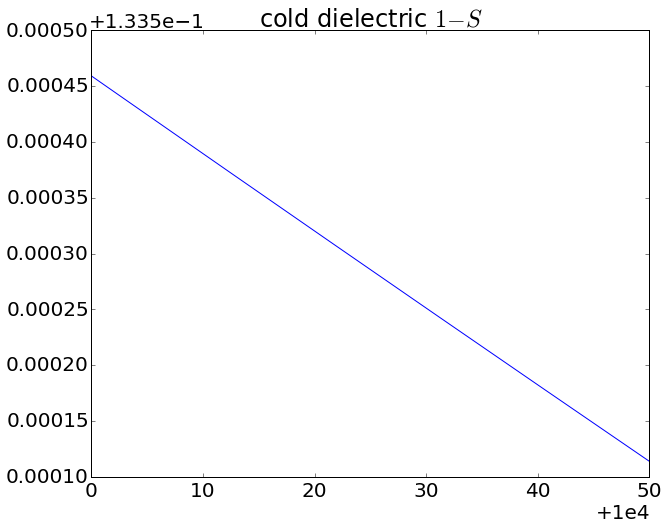

In [27]:
plt.plot(propagator1d_cold.x_coords, 1-np.real(S_cold))
plt.title('cold dielectric $1-S$')

In [28]:
dS_rel = propagator1d_rel.deps[0,0]

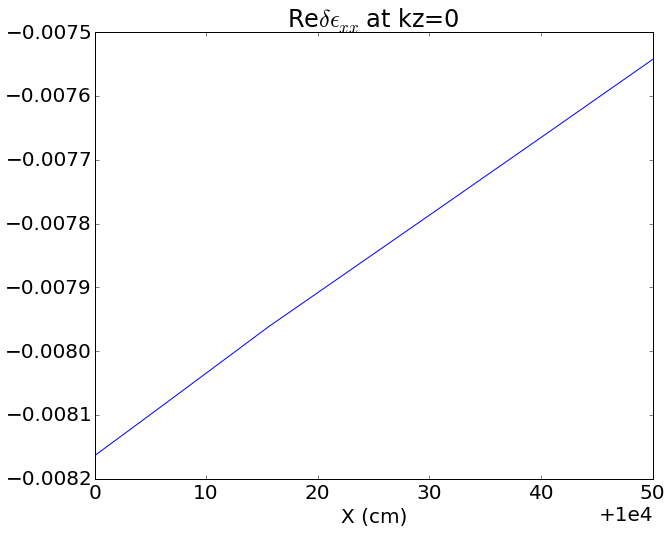

In [29]:
plt.plot(propagator1d_rel.x_coords, np.real(dS_rel[0,0]))
plt.title('Re$\delta \epsilon_{xx}$ at kz=0')
plt.xlabel('X (cm)')

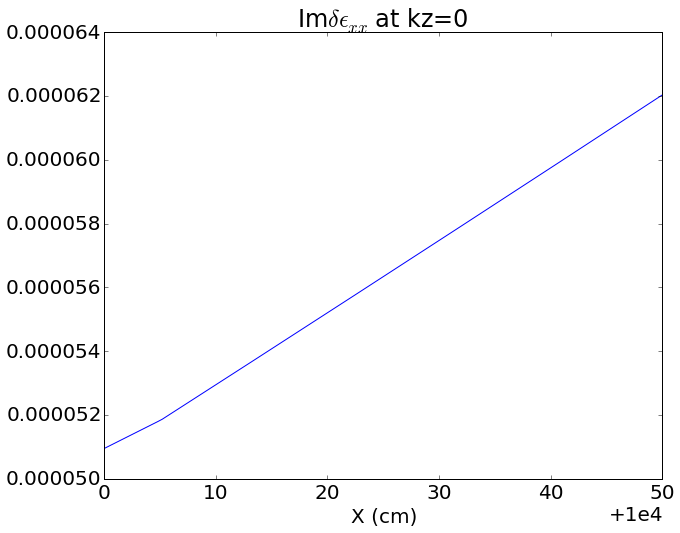

In [30]:
plt.plot(propagator1d_rel.x_coords, np.imag(dS_rel[0,0]))
plt.title('Im$\delta \epsilon_{xx}$ at kz=0')
plt.xlabel('X (cm)')

### 2.2.2 Phase Difference

> Detailed phase information is only available in `debug_mode`

In [31]:
phase_ky_cold = propagator1d_cold.dphi_ky
phase_kz_cold = propagator1d_cold.dphi_kz
phase_ky_rel = propagator1d_rel.dphi_ky 
phase_kz_rel = propagator1d_rel.dphi_kz 

In [32]:
np.max(np.abs(phase_ky_cold - phase_ky_rel))

0.0

In [33]:
np.max(np.abs(phase_kz_cold - phase_kz_rel))

0.0

> **From cold plasma to weakly relativistic plasma, for X-mode, just as for O-mode, the diffraction phase due to $k_y$ and $k_z$ doesn't change.**

In [34]:
phase_deps_rel = propagator1d_rel.dphi_eps

In [35]:
np.max(np.abs(np.real(phase_deps_rel)))

4.123880428784072

In [36]:
np.max(np.imag(phase_deps_rel))

0.032155385712214449

> **Phase due to dielectric tensor difference changes more than $\pi$. A small non-zero imaginary part appears since the third harmonic resonance marginally occurs.**

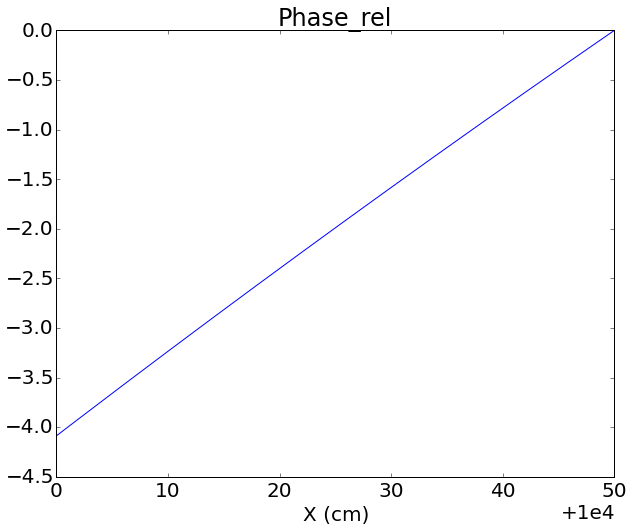

In [37]:
plt.plot(propagator1d_cold.x_coords, np.real(phase_deps_rel[0,0,:]))
plt.title('Phase_rel')
plt.xlabel('X (cm)')

### 2.2.3 Wave Electric Field

#### 2.2.3.1 Difference in E Field

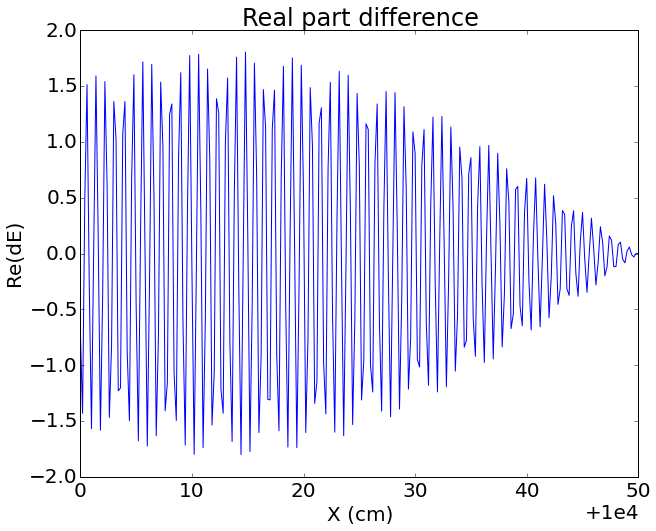

In [38]:
plt.plot(propagator1d_cold.x_coords, np.real(E1_diff[nz/2, ny/2, :]))
plt.title('Real part difference')
plt.xlabel('X (cm)')
plt.ylabel('Re(dE)')

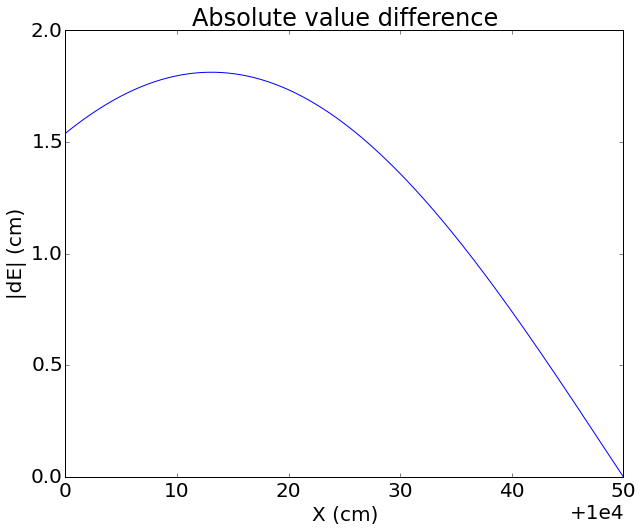

In [39]:
plt.plot(propagator1d_cold.x_coords, np.abs(E1_diff[nz/2, ny/2, :]))
plt.title('Absolute value difference')
plt.xlabel('X (cm)')
plt.ylabel('|dE| (cm)')

# 3. Phase difference as a function of temperature

## 3.1 Phase Difference Curves

Since the main effect of weakly relativistic tensor is introducing an additional phase, we now study the relationship between the phase and temperature.

In [40]:
Te_array = np.arange(1,35,2)

In [41]:
dph_array = np.zeros_like(Te_array, dtype='complex')

### 3.1.1 O-mode

In [42]:
for i, Te in enumerate(Te_array):
    tp.set_parameter1D(Te_0=Te*cgs['keV'], Te_shape='uniform', ne_shape='uniform', R_0=R0, Xmin=R0-50, Xmax=R0+50)
    p1d = tp.create_profile1D(False)
    p1d.setup_interps()
    propagator = prop.ParaxialPerpendicularPropagator1D(plasma=p1d, 
                                                        dielectric_class=dt.RelElectronColdIon,
                                                        polarization='O', 
                                                        direction=-1,
                                                        max_harmonic=1, 
                                                        max_power=1)
    E = propagator.propagate(omega, x_start, x_end, 100, E_start, Y1D, Z1D, debug_mode=True)
    dph_array[i] = np.max(np.abs(propagator.dphi_eps))

Propagator 1D initialized.
Propagator 1D initialized.
Propagator 1D initialized.
Propagator 1D initialized.
Propagator 1D initialized.
Propagator 1D initialized.
Propagator 1D initialized.
Propagator 1D initialized.
Propagator 1D initialized.
Propagator 1D initialized.
Propagator 1D initialized.
Propagator 1D initialized.
Propagator 1D initialized.
Propagator 1D initialized.
Propagator 1D initialized.
Propagator 1D initialized.
Propagator 1D initialized.


C:\Users\lei\Anaconda\lib\site-packages\numpy\core\numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


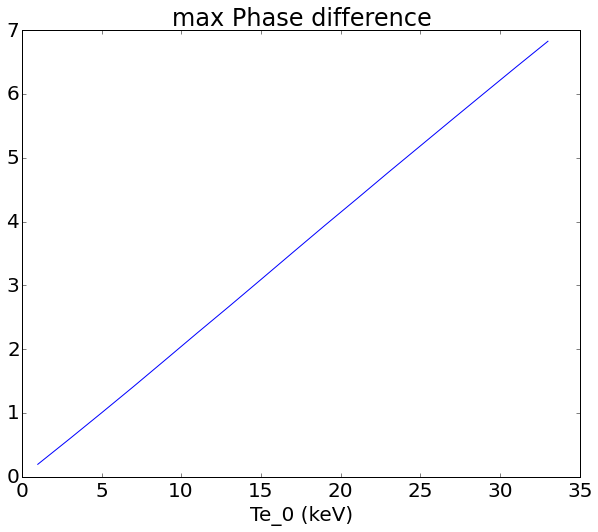

In [43]:
plt.plot(Te_array, np.real(dph_array))
plt.xlabel('Te_0 (keV)')
plt.title('max Phase difference')

> **As expected, the phase difference between weakly relativistic calculation and cold calculation converges to zero when temperature approaches 0.**

Now we include second harmonic contributions.

In [44]:
for i, Te in enumerate(Te_array):
    tp.set_parameter1D(Te_0=Te*cgs['keV'], Te_shape='uniform', ne_shape='uniform', R_0=R0, Xmin=R0-50, Xmax=R0+50)
    p1d = tp.create_profile1D(False)
    p1d.setup_interps()
    propagator = prop.ParaxialPerpendicularPropagator1D(plasma=p1d, 
                                                        dielectric_class=dt.RelElectronColdIon,
                                                        polarization='O', 
                                                        direction=-1,
                                                        max_harmonic=2, 
                                                        max_power=2)
    E = propagator.propagate(omega, x_start, x_end, 100, E_start, Y1D, Z1D, debug_mode=True)
    dph_array[i] = np.max(np.abs(propagator.dphi_eps))

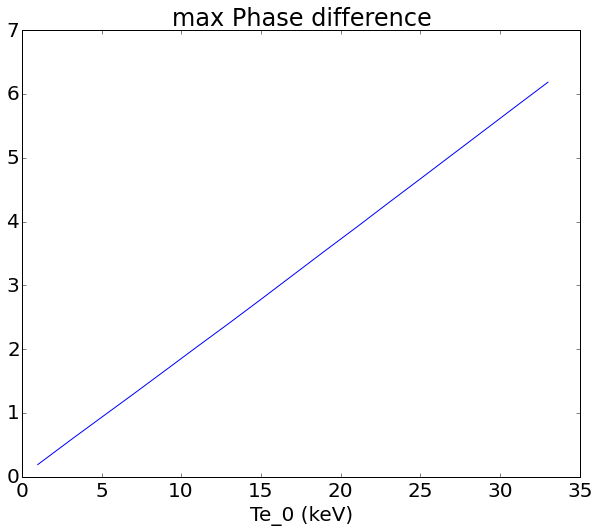

In [45]:
plt.plot(Te_array, dph_array)
plt.xlabel('Te_0 (keV)')
plt.title('max Phase difference')

> **As we can see, including second harmonic terms doens't change the qualitative behavior of the phase difference. The absolute value does get a little smaller than that in first harmonic only case. This can be understood since higher order terms tend to make the difference in dielectric tensor smaller.**

### 3.1.2 X-mode

In [46]:
Te_array = np.logspace(0,2,20)
dph_array = np.empty_like(Te_array)

for i, Te in enumerate(Te_array):
    tp.set_parameter1D(Te_0=Te*cgs['keV'], Te_shape='uniform', ne_shape='uniform', R_0=R0, Xmin=R0-50, Xmax=R0+50)
    p1d = tp.create_profile1D(False)
    p1d.setup_interps()
    propagator = prop.ParaxialPerpendicularPropagator1D(plasma=p1d, 
                                                        dielectric_class=dt.RelElectronColdIon,
                                                        polarization='X', 
                                                        direction=-1,
                                                        max_harmonic=1, 
                                                        max_power=1)
    E = propagator.propagate(omega, x_start, x_end, 100, E_start, Y1D, Z1D, debug_mode=True)
    dph_array[i] = np.max(np.abs(propagator.dphi_eps))

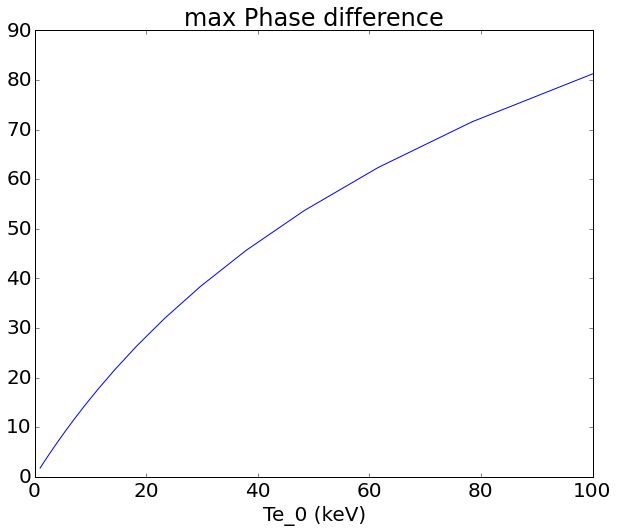

In [47]:
plt.plot(Te_array, dph_array)
plt.xlabel('Te_0 (keV)')
plt.title('max Phase difference')

> **Again, for X-mode, first harmonic only case looks similar to O-mode. However, the phase difference is much larger. This is due to one magnitude of $\lambda$ larger in dielectric tensor elements.**

In [48]:
for i, Te in enumerate(Te_array):
    tp.set_parameter1D(Te_0=Te*cgs['keV'], Te_shape='uniform', ne_shape='uniform', R_0=R0, Xmin=R0-50, Xmax=R0+50)
    p1d = tp.create_profile1D(False)
    p1d.setup_interps()
    propagator = prop.ParaxialPerpendicularPropagator1D(plasma=p1d, 
                                                        dielectric_class=dt.RelElectronColdIon,
                                                        polarization='X', 
                                                        direction=-1,
                                                        max_harmonic=2, 
                                                        max_power=2)
    E = propagator.propagate(omega, x_start, x_end, 100, E_start, Y1D, Z1D, debug_mode=True)
    dph_array[i] = np.max(np.abs(propagator.dphi_eps))

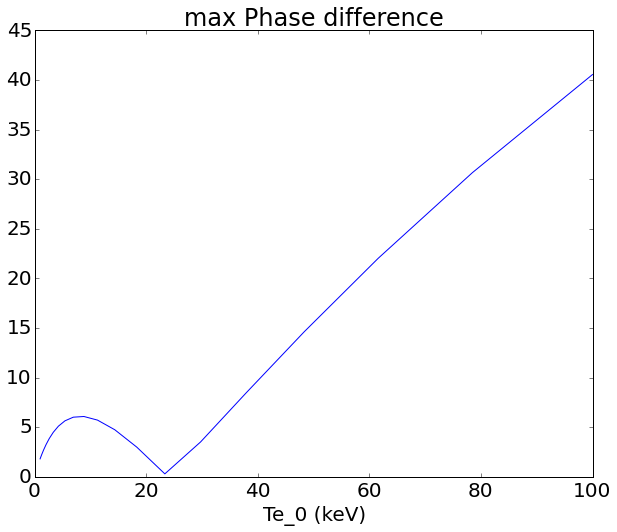

In [49]:
plt.plot(Te_array, dph_array)
plt.xlabel('Te_0 (keV)')
plt.title('max Phase difference')

> **For second harmonic included case, an interesting thing happens. The difference gets to a minimum at around Te=22 keV, and increases for a short period as temperature drops, eventually converges to 0 as expected. The appearence of this minimum is due to the competing relation between second order terms and first order terms.**

In [50]:
for i, Te in enumerate(Te_array):
    tp.set_parameter1D(Te_0=Te*cgs['keV'], Te_shape='uniform', ne_shape='uniform', R_0=R0, Xmin=R0-50, Xmax=R0+50)
    p1d = tp.create_profile1D(False)
    p1d.setup_interps()
    propagator = prop.ParaxialPerpendicularPropagator1D(plasma=p1d, 
                                                        dielectric_class=dt.RelElectronColdIon,
                                                        polarization='X', 
                                                        direction=-1,
                                                        max_harmonic=3, 
                                                        max_power=3)
    E = propagator.propagate(omega, x_start, x_end, 100, E_start, Y1D, Z1D, debug_mode=True)
    dph_array[i] = np.max(np.abs(propagator.dphi_eps))

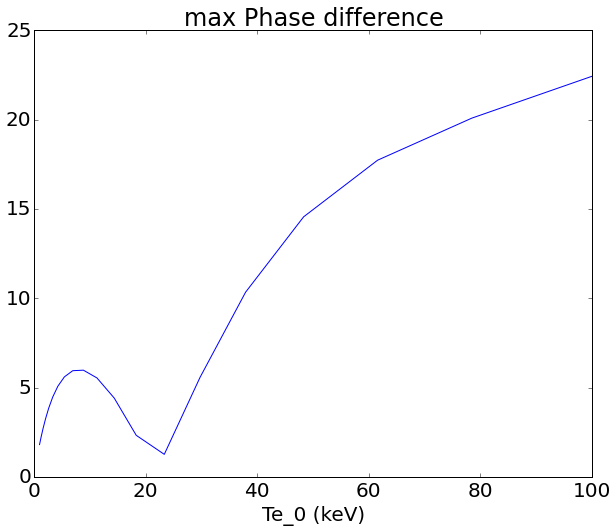

In [51]:
plt.plot(Te_array, dph_array)
plt.xlabel('Te_0 (keV)')
plt.title('max Phase difference')

> ** Again, when we includes 3rd harmonics, the phase difference at higher temperature gets significantly smaller. The third order terms are important in these temperature region. We briefly show the 4th and 5th order terms included cases below, they look very similar to 3rd order case.**

In [52]:
for i, Te in enumerate(Te_array):
    tp.set_parameter1D(Te_0=Te*cgs['keV'], Te_shape='uniform', ne_shape='uniform', R_0=R0, Xmin=R0-50, Xmax=R0+50)
    p1d = tp.create_profile1D(False)
    p1d.setup_interps()
    propagator = prop.ParaxialPerpendicularPropagator1D(plasma=p1d, 
                                                        dielectric_class=dt.RelElectronColdIon,
                                                        polarization='X', 
                                                        direction=-1,
                                                        max_harmonic=4, 
                                                        max_power=4)
    E = propagator.propagate(omega, x_start, x_end, 100, E_start, Y1D, Z1D, debug_mode=True)
    dph_array[i] = np.max(np.abs(propagator.dphi_eps))

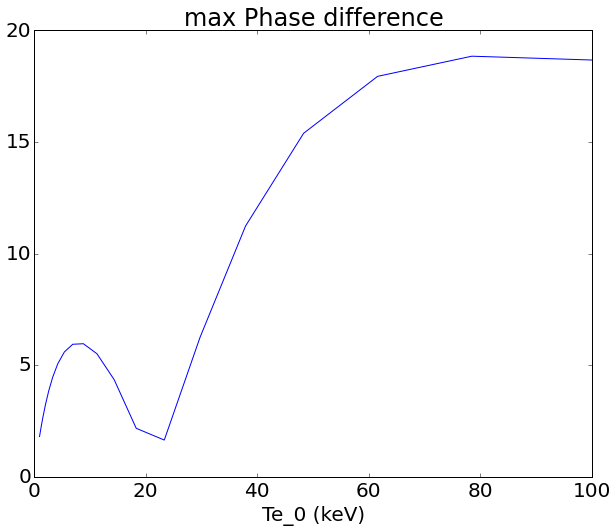

In [53]:
plt.plot(Te_array, dph_array)
plt.xlabel('Te_0 (keV)')
plt.title('max Phase difference')

> **4th order contribution tends to fill up the minimum. Just as 3rd order terms did to 2nd order minimum.**

In [54]:
for i, Te in enumerate(Te_array):
    tp.set_parameter1D(Te_0=Te*cgs['keV'], Te_shape='uniform', ne_shape='uniform', R_0=R0, Xmin=R0-50, Xmax=R0+50)
    p1d = tp.create_profile1D(False)
    p1d.setup_interps()
    propagator = prop.ParaxialPerpendicularPropagator1D(plasma=p1d, 
                                                        dielectric_class=dt.RelElectronColdIon,
                                                        polarization='X', 
                                                        direction=-1,
                                                        max_harmonic=5, 
                                                        max_power=5)
    E = propagator.propagate(omega, x_start, x_end, 100, E_start, Y1D, Z1D, debug_mode=True)
    dph_array[i] = np.max(np.abs(propagator.dphi_eps))

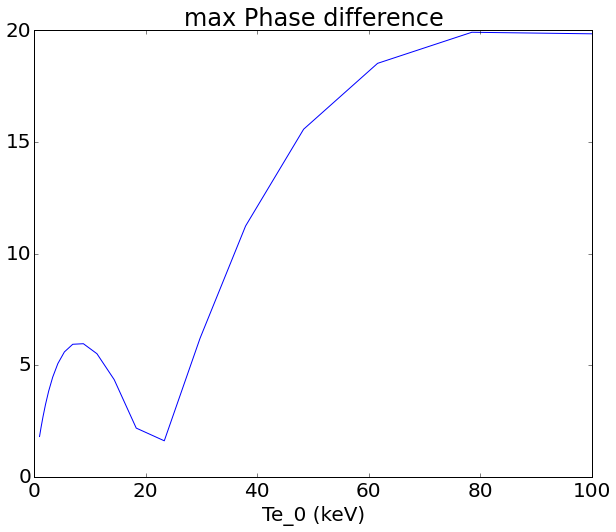

In [55]:
plt.plot(Te_array, dph_array)
plt.xlabel('Te_0 (keV)')
plt.title('max Phase difference')

# 4. Conclusion

- **In non-resonant region, the main difference between weakly relativistic dielectric tensor and the cold plasma dielectric tensor on perpendicularly propagating waves is an additional real phase. This phase can be comparable to $\pi$ even for fairly low temperature, e.g. Te=1keV.** 
- **Depending on the temperature, the appropriate order of harmonics needed to be included will change. For waves frequency slightly above second harmonics**